In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from mpl_toolkits.mplot3d import Axes3D   
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


# generating a data set from real data
load your text file with data as file. If using LLR2 or LLR3 data, all data are in 1 file. In 

7.152557373046875e-05


Text(0.5, 1.0, 'B_y vs X')

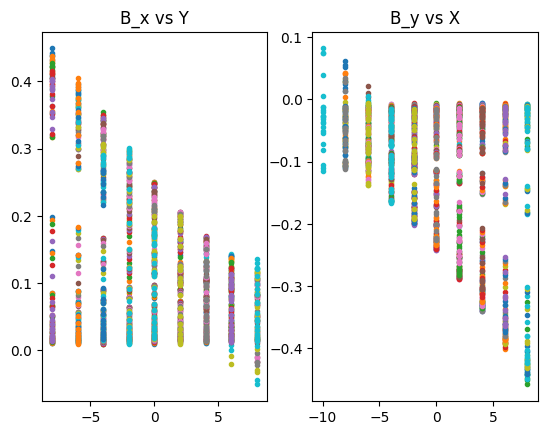

In [71]:



start=time.time()
end = time.time()
print(end-start)

#file = 'PMQLLR02_2021_11_15_14.27.txt'
file = 'PQMLLR3_2021_09_30.txt'
#file = '/Users/sumitnayak/Downloads/Datasets_QPM/QPMLLR01_SNAR_1-1.5-3_data2023_07_17_09.47.txt'

data = np.genfromtxt(file)

x_local= data[0:,5]
y_local= data[0:,6]
z_local= data[0:,7]
B_x = data[0:,8]
B_y = data[0:,9]
B_z = data[0:,10]

step=len(np.unique(z_local)) #----------> number after which Z values repeated / number of diff Z position
num=len(x_local) #-------------->Total Number of data points for a single parameter

#----------------------- Value at different fixed Z values -------------------

x_local_Z = [x_local[j:num:step]  for j in range(step)]
y_local_Z = [y_local[j:num:step]  for j in range(step)]
z_local_Z = [z_local[j:num:step]  for j in range(step)]
Bx_Z = [B_x[j:num:step]  for j in range(step)]
By_Z = [B_y[j:num:step]  for j in range(step)]
Bz_Z = [B_z[j:num:step]  for j in range(step)]

z_local_val= np.unique(z_local)
#print(z_local_val.shape)

plt.subplot(1,2,1)
plt.plot(y_local_Z,Bx_Z,'.')
plt.title('B_x vs Y')
plt.subplot(1,2,2)
plt.plot(x_local_Z,By_Z,'.')
plt.title('B_y vs X')



In [72]:
def alpha_func_x(X,a1,a2):
    G,alpha=X
    return [G * np.sin(alpha) - a1 ,
            G * np.cos(alpha) - a2 ] 

In [73]:
def solve_func_x(var,a1,a2):
    return fsolve(alpha_func_x,x0=var,args=(a1,a2))


In [74]:
def alpha_func_y(Y,b1,b2):
    G,alpha=Y
    return [G * np.cos(alpha) - b1 ,
            -G * np.sin(alpha) - b2 ]

In [75]:
def solve_func_y(var,b1,b2):
    return fsolve(alpha_func_y,x0=var,args=(b1,b2))


In [76]:
def fit_func(X, B_00, B_10, B_01):
    x,y = X
    return B_00 + B_10*x + B_01*y

In [77]:
#--------------- Fitting Bx & By Separately to determine Bx_00, Bx_10,Bx_01,By_00, By_10, By_01-----------


param_X,param_Y =[],[]

x = np.array(x_local_Z) # this is of 19x53 order matrix
y = np.array(y_local_Z) # this is of 19x53 order matrix
z1 = np.array(Bx_Z)
z2 = np.array(By_Z)

for i in range(step):
    param1,pocv1=(curve_fit(fit_func, (x[i],y[i]), z1[i]))
    param_X.append(param1)
    param2,pocv2=(curve_fit(fit_func, (x[i],y[i]), z2[i]))
    param_Y.append(param2)
        
param_X=np.array(param_X)
param_Y=np.array(param_Y)
#print(param_Y)
#print(param_X)

Bx_00 = param_X[0:,0]; Bx_10 = param_X[0:,1]; Bx_01 = param_X[0:,2]
By_00 = param_Y[0:,0]; By_10 = param_Y[0:,1]; By_01 = param_Y[0:,2]



In [78]:
# ------------------------------------ Calculating Gx & Alpha_x

guess = np.array([1,1])
vector_func = np.vectorize(solve_func_x,excluded=['var'], otypes=[list])
root_x = vector_func(var = guess, a1=(Bx_10),a2 = (Bx_01))
root_x= np.stack(root_x,axis=0)
#print(root_x)

G_x = root_x[0:,0]
alpha_x = (root_x[0:,1])*57.29

# ------------------------------------ Calculating Gy & Alpha_y

vector_func = np.vectorize(solve_func_y,excluded=['var'], otypes=[list])
root_y = vector_func(var = guess, b1=(By_10),b2 = (By_01))
root_y= np.stack(root_y,axis=0)
#print(root_y)

G_y = root_y[0:,0]
alpha_y = (root_y[0:,1])*57.29

# ------------------------------------ Calculating Magnetic Centre (Xc & Yc)

magcentre_y = -(Bx_00/Bx_01) 
magcentre_x = -(By_00/By_10)



In [79]:
def Bx_func(x,y, alphaX, alphaY, Gx, Gy, magCentreX, magCentreY):
    
    return math.sin(alphaX*math.pi/180)*Gx*(x - magCentreX)/10 + math.cos(alphaY*math.pi/180)*Gy*(y - magCentreY)/10

In [80]:
def By_func(x,y, alphaX, alphaY, Gx, Gy, magCentreX, magCentreY):
    
    return math.cos(alphaX*math.pi/180)*Gx*(x - magCentreX)/10 - math.sin(alphaY*math.pi/180)*Gy*(y - magCentreY)/10

In [96]:
def generateB(z_val, alphaX, alphaY, GX, GY, magcentreX, magcentreY):

    #constants to change depending on magnet
    #LLR2
    #gridRange = 19
    #fringeLength = 20
    #key = "LLR2/3Dcavity2"

    #LLR3
    gridRange = 31
    fringeLength = 50
    key = "LLR3/3Dcavity3"
    #-----------------------------------------------------------------------

    
    #generate x,y inside bore radius, this is for QPMLLR2, so radius is 9 mm
    xArray = []
    yArray = []
    bx = str(gridRange) + " "
    
    
    for i in range(gridRange):
        xArray.append(-(gridRange-1)/2 + i)
        bx += str((-(gridRange -1)+i)*1e-3) + " "

    bx += "\n" + str(gridRange) + " "
    for i in range(gridRange):
        yArray.append(-(gridRange-1)/2 + i)
        bx += str((-(gridRange-1)/2+i)*1e-3) + " "

    bx += "\n" + str(len(z_val)) + " "    
    for i in range(len(z_val)):
        bx += str((z_val[i] + fringeLength)*1e-3) +" "
    bx += "\n"

    
    by = bx
    bz = bx
    ex = bx
    ey = bx
    ez = bx
    
    limit = len(z_val) - 1 
    for i in range(len(z_val)):
        for y in yArray:
            for x in xArray:
                Bx = math.ceil(1000000*Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha_x[i+1], alpha_y[i+1], GX[i+1], GY[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]) -Bx_func(x,y, alpha_x[i-1], alpha_y[i-1], GX[i-1], GY[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha_x[i+1], alpha_y[i+1], GX[i+1], GY[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha_x[i-1], alpha_y[i-1], GX[i-1], GY[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentre_x[i])*math.sin(alpha_x[i]*math.pi/180) + (y-magcentre_y[i])*math.cos(alpha_y[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000


                bx += str(Bx) + " "
                by += str(By) + " "
                bz += str(Bz) + " "
                ex += "0 "
                ey += "0 "
                ez += "0 "

            bx += "\n"
            by += "\n"
            bz += "\n"
            ex += "\n"
            ey += "\n"
            ez += "\n"

    with open(key + ".ex", "w") as file:
        file.writelines(ex)
    with open(key + ".ey", "w") as file:
        file.writelines(ey)
    with open(key + ".ez", "w") as file:
        file.writelines(ez)
        
    with open(key + ".bx", "w") as file:
        file.writelines(bx)
    with open(key + ".by", "w") as file:
        file.writelines(by)
    with open(key + ".bz", "w") as file:
        file.writelines(bz)


    #this part is only for double checking if the fields are similar
    
    results = ""
    for y in yArray:
        for x in xArray:
            for i in range(len(z_val)):

                Bx = math.ceil(1000000*Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha_x[i+1], alpha_y[i+1], GX[i+1], GY[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha_x[i], alpha_y[i], GX[i], GY[i], magcentre_x[i], magcentre_y[i]) -Bx_func(x,y, alpha_x[i-1], alpha_y[i-1], GX[i-1], GY[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha_x[i+1], alpha_y[i+1], GX[i+1], GY[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha_x[i-1], alpha_y[i-1], GX[i-1], GY[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentre_x[i])*math.sin(alpha_x[i]*math.pi/180) + (y-magcentre_y[i])*math.cos(alpha_y[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000

                results += "0 0 0 0 0 " + str(x) + " " + str(y) + " " + str(z_val[i]) + " " + str(Bx) + " " + str(By) + " " + str(Bz) + "\n"


    with open("PQMLLR3_generated.txt","w") as file:
        file.writelines(results)
    

    return

In [97]:
generatedData = generateB(z_local_val, alpha_x, alpha_y, G_x, G_y, magcentre_x, magcentre_y)

In [98]:
def runOnceMore():
    file = 'PQMLLR3_generated.txt'

    data = np.genfromtxt(file)
    
    x_local= data[0:,5]
    y_local= data[0:,6]
    z_local= data[0:,7]
    B_x = data[0:,8]
    B_y = data[0:,9]
    B_z = data[0:,10]
    
    step=len(np.unique(z_local)) #----------> number after which Z values repeated / number of diff Z position
    num=len(x_local) #-------------->Total Number of data points for a single parameter
    
    #----------------------- Value at different fixed Z values -------------------
    
    x_local_Z = [x_local[j:num:step]  for j in range(step)]
    y_local_Z = [y_local[j:num:step]  for j in range(step)]
    z_local_Z = [z_local[j:num:step]  for j in range(step)]
    Bx_Z = [B_x[j:num:step]  for j in range(step)]
    By_Z = [B_y[j:num:step]  for j in range(step)]
    Bz_Z = [B_z[j:num:step]  for j in range(step)]
    
    z_local_val= np.unique(z_local)
    #print(z_local_val.shape)
    
    plt.subplot(1,2,1)
    plt.plot(y_local_Z,Bx_Z,'.')
    plt.title('B_x vs Y')
    plt.subplot(1,2,2)
    plt.plot(x_local_Z,By_Z,'.')
    plt.title('B_y vs X')


    param_X,param_Y =[],[]

    
    x = np.array(x_local_Z) # this is of 19x53 order matrix
    y = np.array(y_local_Z) # this is of 19x53 order matrix
    z1 = np.array(Bx_Z)
    z2 = np.array(By_Z)
    
    for i in range(step):
        param1,pocv1=(curve_fit(fit_func, (x[i],y[i]), z1[i]))
        param_X.append(param1)
        param2,pocv2=(curve_fit(fit_func, (x[i],y[i]), z2[i]))
        param_Y.append(param2)
            
    param_X=np.array(param_X)
    param_Y=np.array(param_Y)
    #print(param_Y)
    #print(param_X)
    
    Bx_00 = param_X[0:,0]; Bx_10 = param_X[0:,1]; Bx_01 = param_X[0:,2]
    By_00 = param_Y[0:,0]; By_10 = param_Y[0:,1]; By_01 = param_Y[0:,2]
    
    
    guess = np.array([1,1])
    vector_func = np.vectorize(solve_func_x,excluded=['var'], otypes=[list])
    root_x = vector_func(var = guess, a1=(Bx_10),a2 = (Bx_01))
    root_x= np.stack(root_x,axis=0)
    #print(root_x)
    
    G_x = root_x[0:,0]
    alpha_x = (root_x[0:,1])*57.29
    
    vector_func = np.vectorize(solve_func_y,excluded=['var'], otypes=[list])
    root_y = vector_func(var = guess, b1=(By_10),b2 = (By_01))
    root_y= np.stack(root_y,axis=0)
    #print(root_y)
    
    G_y = root_y[0:,0]
    alpha_y = (root_y[0:,1])*57.29
    
    # ------------------------------------ Calculating Magnetic Centre (Xc & Yc)
    
    magcentre_y = -(Bx_00/Bx_01) 
    magcentre_x = -(By_00/By_10)

    #generateB(z_local_val, alpha_x, alpha_y, G_x, G_y, magcentre_x, magcentre_y)
    
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,Bx_00,'o-',label='Bx')
    plt.plot(z_local_val,By_00,'o-',label='By')
    #plt.ylim(-0.05,+0.05)
    plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,Bx_10,'o-',label='Bx')
    plt.plot(z_local_val,By_10,'o-',label='By')
    #plt.ylim(-0.1,0.01)
    plt.title('[T/mm] (fit parameter B\u2081\u2080)')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,Bx_01,'o-',label='Bx')
    plt.plot(z_local_val,By_01,'o-',label='By')
    #plt.ylim(-0.1,0.01)
    plt.title('[T/mm] (fit parameter B\u2080\u2081)')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,alpha_x,'o-',label='\u03B1_x')
    plt.plot(z_local_val,alpha_y,'o-',label='\u03B1_y')
    #plt.ylim(-.1,.1)
    plt.title('Skew Angle {Degree} (\u03B1) {rotation of field} ')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,G_x,'o-',label='Gx')
    plt.plot(z_local_val,G_y,'o-',label='Gy')
    #plt.ylim(-.11,.05)
    plt.title('Gradient of the field [T/mm] ')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20,2))   
    plt.plot(z_local_val,magcentre_x,'o-',label='Bx')
    plt.plot(z_local_val,magcentre_y,'o-',label='By')
    #plt.ylim(-.5,.5)
    plt.title('Magnet Center Coordinate (mm) ')
    plt.legend(loc='best')
    plt.grid()
    plt.show()



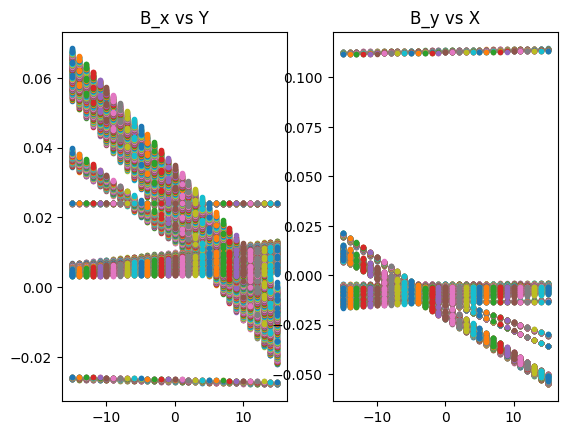

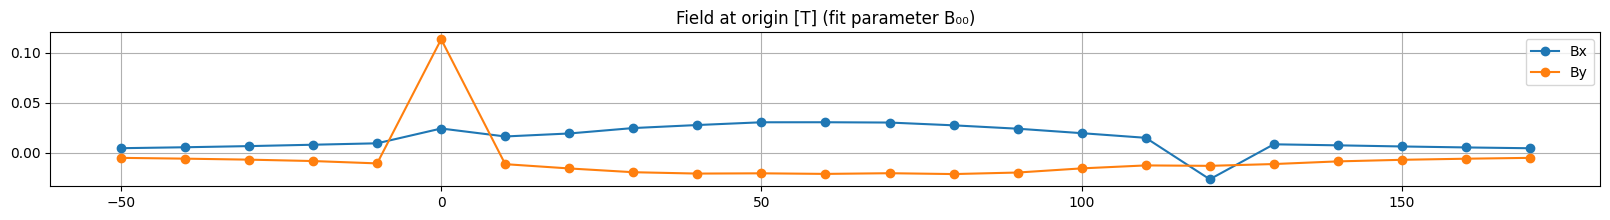

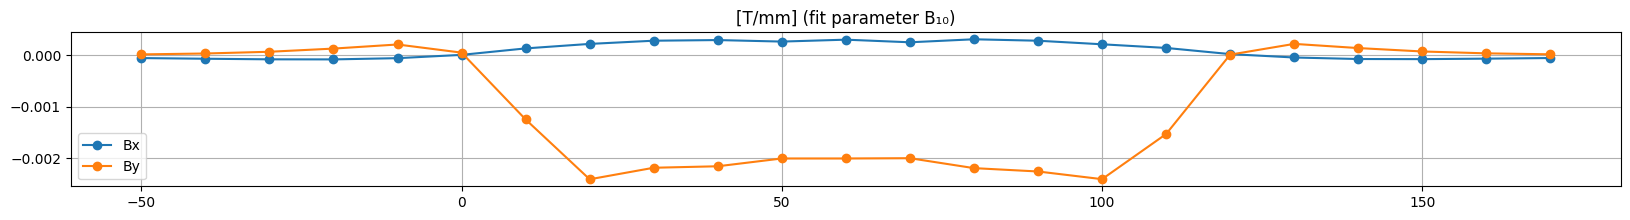

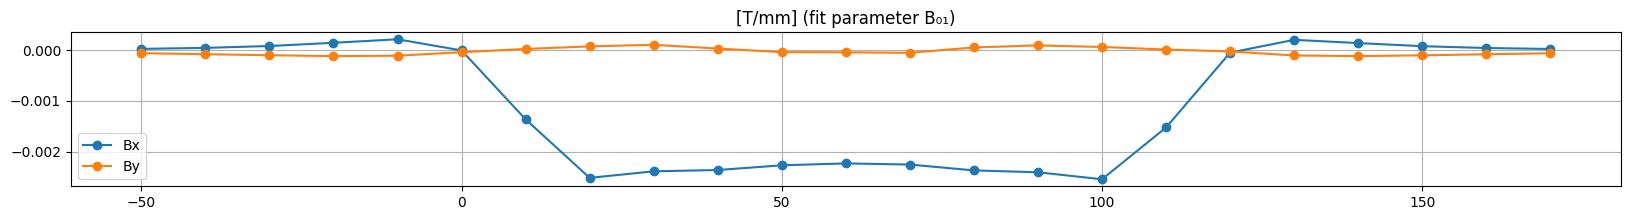

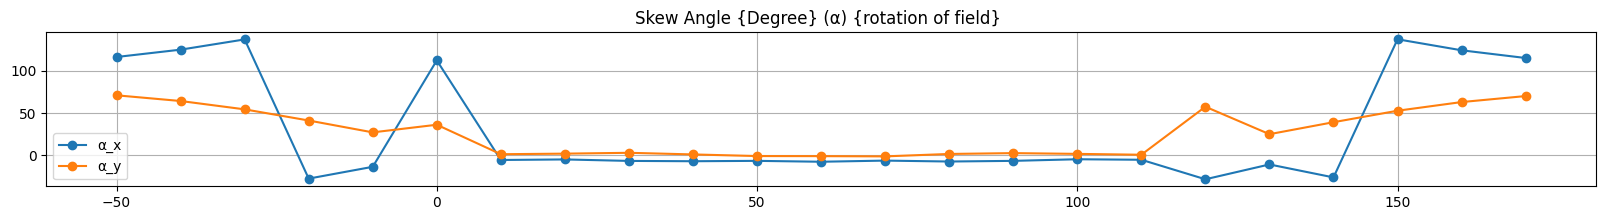

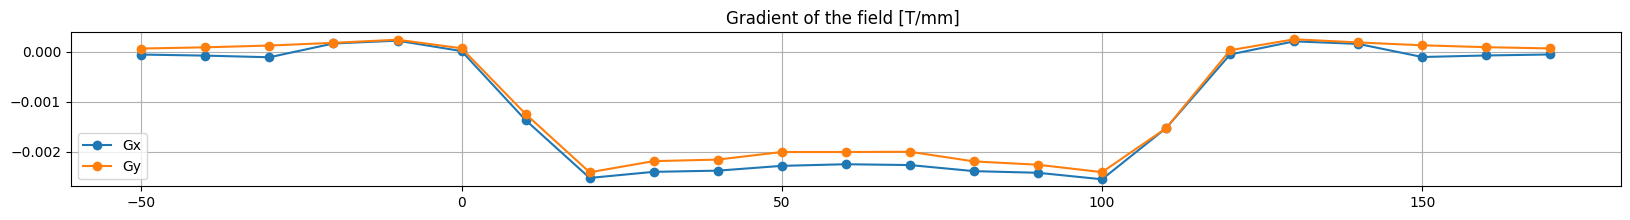

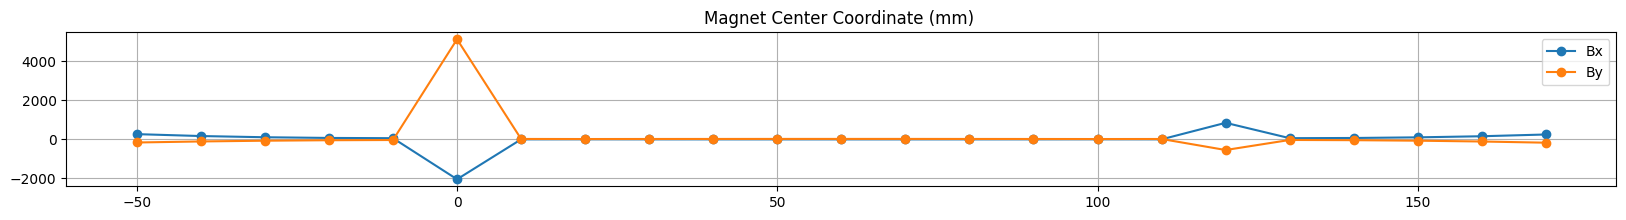

In [99]:
runOnceMore()

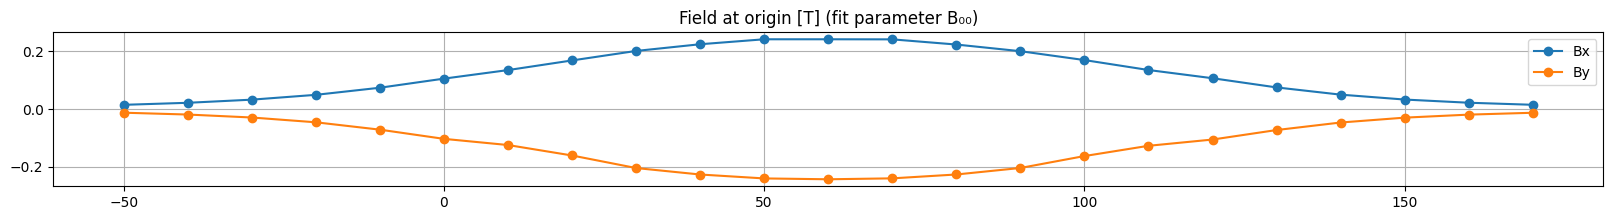

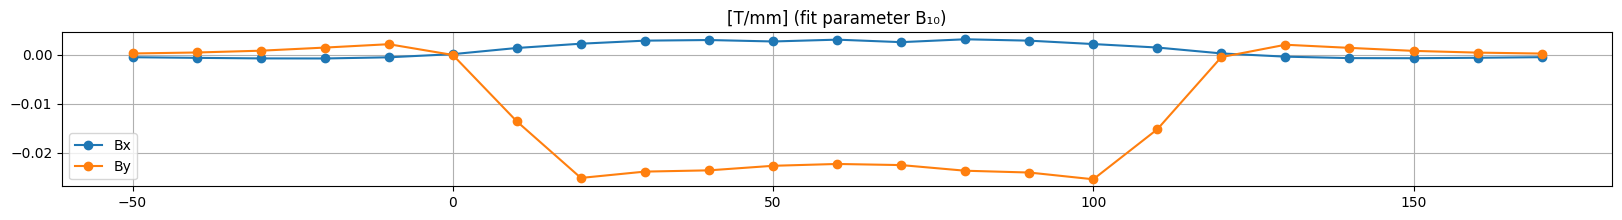

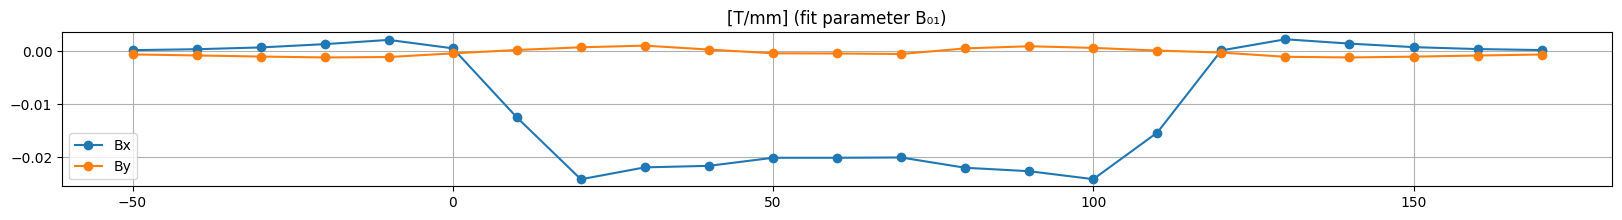

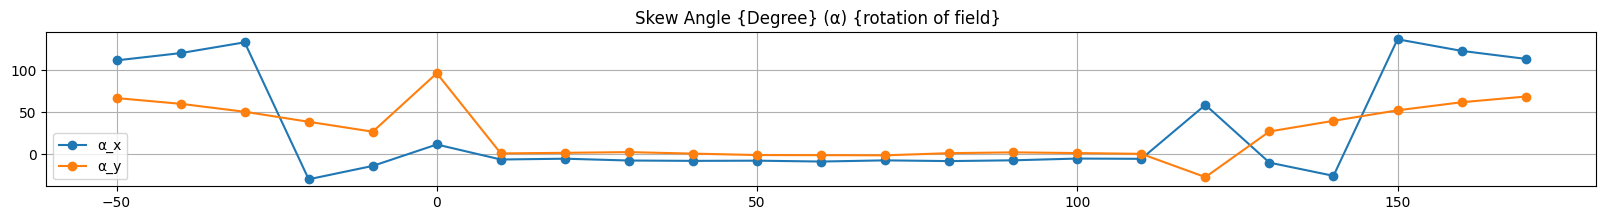

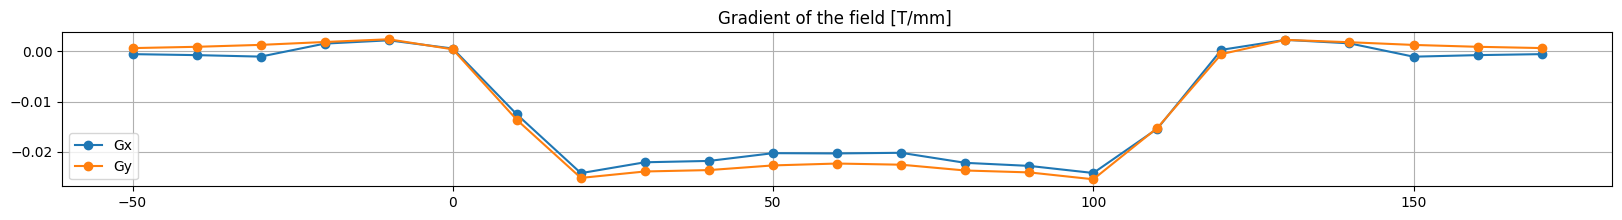

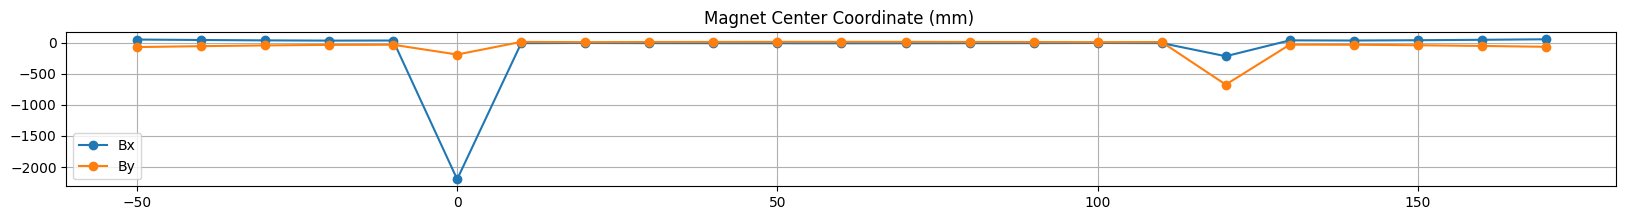

In [90]:

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_00,'o-',label='Bx')
plt.plot(z_local_val,By_00,'o-',label='By')
#plt.ylim(-0.05,+0.05)
plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_10,'o-',label='Bx')
plt.plot(z_local_val,By_10,'o-',label='By')
#plt.ylim(-0.1,0.01)
plt.title('[T/mm] (fit parameter B\u2081\u2080)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_01,'o-',label='Bx')
plt.plot(z_local_val,By_01,'o-',label='By')
#plt.ylim(-0.1,0.01)
plt.title('[T/mm] (fit parameter B\u2080\u2081)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,alpha_x,'o-',label='\u03B1_x')
plt.plot(z_local_val,alpha_y,'o-',label='\u03B1_y')
#plt.ylim(-.1,.1)
plt.title('Skew Angle {Degree} (\u03B1) {rotation of field} ')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,G_x,'o-',label='Gx')
plt.plot(z_local_val,G_y,'o-',label='Gy')
#plt.ylim(-.11,.05)
plt.title('Gradient of the field [T/mm] ')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,magcentre_x,'o-',label='Bx')
plt.plot(z_local_val,magcentre_y,'o-',label='By')
#plt.ylim(-.5,.5)
plt.title('Magnet Center Coordinate (mm) ')
plt.legend(loc='best')
plt.grid()
plt.show()


In [14]:
from scipy.optimize import least_squares

def simult_fit(X,z1,w1,x1,y1):
    Bx_00, Bx_10, Bx_01,By_00, By_10, By_01 = X
    return np.array([ z1-(Bx_00 + Bx_10*x1 + Bx_01*y1) ,
                     w1-(By_00 + By_10*x1 + By_01*y1) ])
def solve_func(var,z1,w1,x1,y1):
    cc = least_squares(simult_fit,var,args=(z1,w1,x1,y1))
    return cc.x

guess_initial=np.array([0.02,0,-0.1,0.02,-0.1,0]) #----------->assumed from graph plotted earlier
vector_func = np.vectorize(solve_func,excluded=['var'], otypes=[list])
dd = vector_func(var = guess_initial, z1 = Bx_Z,w1 = np.array(By_Z),x1 = np.array(x_local_Z),y1 = np.array(y_local_Z))
dd= np.stack(dd,axis=0)

print(dd.shape)


(19, 53)


In [7]:
######### Finding the Centre of the Circle #########

import sympy as sym
x,y,r = sym.symbols('x,y,r')
x1 = sym.Symbol('x1')
x2 = sym.Symbol('x2')
x3 = sym.Symbol('x3')
y1 = sym.Symbol('y1')
y2 = sym.Symbol('y2')
y3 = sym.Symbol('y3')
eq1 = sym.Eq((x-x1)**2 + (y-y1)**2,r**2)
eq2 = sym.Eq((x-x2)**2 + (y-y2)**2,r**2)
eq3 = sym.Eq((x-x3)**2 + (y-y3)**2,r**2)

result = sym.solve([eq1,eq2,eq3],(x,y,r))
print((result))


[((x1**2*y2 - x1**2*y3 - x2**2*y1 + x2**2*y3 + x3**2*y1 - x3**2*y2 + y1**2*y2 - y1**2*y3 - y1*y2**2 + y1*y3**2 + y2**2*y3 - y2*y3**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -(x1**2*x2 - x1**2*x3 - x1*x2**2 + x1*x3**2 - x1*y2**2 + x1*y3**2 + x2**2*x3 - x2*x3**2 + x2*y1**2 - x2*y3**2 - x3*y1**2 + x3*y2**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -sqrt((x1**2 - 2*x1*x2 + x2**2 + y1**2 - 2*y1*y2 + y2**2)*(x1**2 - 2*x1*x3 + x3**2 + y1**2 - 2*y1*y3 + y3**2)*(x2**2 - 2*x2*x3 + x3**2 + y2**2 - 2*y2*y3 + y3**2))/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2))), ((x1**2*y2 - x1**2*y3 - x2**2*y1 + x2**2*y3 + x3**2*y1 - x3**2*y2 + y1**2*y2 - y1**2*y3 - y1*y2**2 + y1*y3**2 + y2**2*y3 - y2*y3**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -(x1**2*x2 - x1**2*x3 - x1*x2**2 + x1*x3**2 - x1*y2**2 + x1*y3**2 + x2**2*x3 - x2*x3**2 + x2*y1**2 - x2*y3**2 - x3*y1**2 + x3*y2**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), sqrt((x1**2 - 2*x1*x2 + x2**2 + y1**2 

In [8]:
import sympy as sym
import numpy as np
x,y,r = sym.symbols('x,y,r')

filename_1 = '/Users/sumitnayak/Downloads/Datasets_QPM/Centre of Bore/PQMLLR03_exitplane_2023.07.03.txt'

data_1 = np.genfromtxt(filename_1) 

x1 = data_1[0:,0] ; y1 = data_1[0:,1]
x2 = data_1[0:,2] ; y2 = data_1[0:,3]
x3 = data_1[0:,4] ; y3 = data_1[0:,5]

for i in range(2):
    eq1 = sym.Eq((x-x1[i])**2 + (y-y1[i])**2,r**2)
    eq2 = sym.Eq((x-x2[i])**2 + (y-y2[i])**2,r**2)
    eq3 = sym.Eq((x-x3[i])**2 + (y-y3[i])**2,r**2)

    result = sym.solve([eq1,eq2,eq3],(x,y,r))
    print(result)


FileNotFoundError: /Users/sumitnayak/Downloads/Datasets_QPM/Centre of Bore/PQMLLR03_exitplane_2023.07.03.txt not found.

In [ ]:
import sympy as sym
import numpy as np
x,y,r = sym.symbols('x,y,r')

x1 = 1622 ; y1 = 525
x2 = 303 ; y2 = 332
x3 = 1076 ; y3 = 19


eq1 = sym.Eq((x-x1)**2 + (y-y1)**2,r**2)
eq2 = sym.Eq((x-x2)**2 + (y-y2)**2,r**2)
eq3 = sym.Eq((x-x3)**2 + (y-y3)**2,r**2)

result = sym.solve([eq1,eq2,eq3],(x,y,r))
print(result)
